<a href="https://colab.research.google.com/github/hiteshK03/Product-review-classifier/blob/main/NN_nlp_assignment_torch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%%capture
!pip install -U pip setuptools wheel
!pip install -U spacy[cuda101,transformers,lookups]
!python -m spacy download en_core_web_trf
!python -m spacy download en
!pip install -U torchtext
# !pip install -U torchtext==0.8.0

In [ ]:
import re
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt

import torch
import torchtext
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import SubsetRandomSampler

import spacy
from torchtext.legacy.data import Field, BucketIterator, TabularDataset
import io
from imblearn.over_sampling import RandomOverSampler

import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
nltk.download('punkt')


s = "string.With. Punctuation?"
s = re.sub(r'[^\w\s]',' ',s)
s

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


'string With  Punctuation '

<h2>About the task:</h2>

<ul>
<li> You are provided with a codeflow- which consists of functions to be implemented(MANDATORY).
<li> You need to implement each of the functions mentioned below, you may add your own function parameters if needed(not to main).
<li> Execute your code using the provided auto.py script(NO EDITS PERMITTED) as your code will be evaluated using an auto-grader.
</ul>

In [ ]:
train_data = pd.read_csv('/content/train.csv')
train_data['reviews']

0        This book was very informative, covering all a...
1        I am already a baseball fan and knew a bit abo...
2        I didn't like this product it smudged all unde...
3        I simply love the product. I appreciate print ...
4        It goes on very easily and makes my eyes look ...
                               ...                        
49995                         it does not work((((((((((((
49996    Really worthless, loud motor with absolutely n...
49997    Don't waste your money on this. It does nothin...
49998    Product does not remove ear wax. No suction, j...
49999    If you wear hearing aids these are great for r...
Name: reviews, Length: 50000, dtype: object

In [ ]:
train_data.dropna(axis=0, how='any', inplace=True)
train_data = train_data[train_data['ratings'] >= 1]
train_data = train_data[train_data['ratings'] <= 5]
print(len(train_data))

50000


In [ ]:
def encode_data(text, L):
    # This function will be used to encode the reviews using a dictionary(created using corpus vocabulary) 
    
    # Example of encoding :"The food was fabulous but pricey" has a vocabulary of 4 words, each one has to be mapped to an integer like: 
    # {'The':1,'food':2,'was':3 'fabulous':4 'but':5 'pricey':6} this vocabulary has to be created for the entire corpus and then be used to 
    # encode the words into integers 

    spacy_en = spacy.load('en_core_web_sm')
    def spacy_tokenizer(text):
        return [toke.text for toke in spacy_en.tokenizer(text)]

    text_field = torchtext.legacy.data.Field(
      tokenize    = spacy_tokenizer,
      batch_first = True,
      fix_length = L
    )

    text = list(map(text_field.preprocess, text))

    text_field.build_vocab(text, vectors='glove.42B.300d')
    text = perform_padding(text, text_field)
    text = text_field.numericalize(text)
    return text, text_field

def convert_to_lower(text):
    # return the reviews after convering then to lowercase
    return text.lower()


def remove_punctuation(text):
    # return the reviews after removing punctuations
    text = re.sub(r"n\'t", " not", text)
    text = re.sub(r"\'re", " are", text)
    text = re.sub(r"\'s", " is", text)
    text = re.sub(r"\'d", " would", text)
    text = re.sub(r"\'ll", " will", text)
    text = re.sub(r"\'ve", " have", text)
    text = re.sub(r"\'m", " am", text)
    text = re.sub(r'[^\w\s]',' ',text)
    text = re.sub(' +', ' ',text)
    return text

def remove_stopwords(text):
    # return the reviews after removing the stopwords
    stop_words = stopwords.words('english')
    stop_words.remove('not')
    return ' '.join([w for w in text if not w in stop_words])  

def perform_tokenization(text):
    # return the reviews after performing tokenization
    return word_tokenize(text)

def perform_padding(data, TEXT):
    # return the reviews after padding the reviews to maximum length
    # return pad_sequences(data, maxlen=max_len)
    return TEXT.pad(data)

def preprocess_review(text):
    out = convert_to_lower(text)
    out = remove_punctuation(out)
    out = perform_tokenization(out)
    # out = remove_stopwords(out)
    return out

def preprocess_data(data, L):
    # make all the following function calls on your data
    # EXAMPLE:->

    review = data.apply(lambda row: preprocess_review(row['reviews']), axis=1)
    review, text_field = encode_data(review, L)
    return review, text_field

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
class_sample_count = np.array([len(np.where(train_data['ratings'].values==t)[0]) for t in np.unique(train_data['ratings'].values)])
print(class_sample_count)
# print(1/0)
weight = 50000 / class_sample_count
weight = torch.tensor(weight).float().to(device)
print(weight)

[ 4059  2265  3612  6871 33193]
tensor([12.3183, 22.0751, 13.8427,  7.2770,  1.5063], device='cuda:0')


In [ ]:
train_X_tensor, text_field = preprocess_data(train_data, 30)
train_Y_tensor = torch.tensor(train_data['ratings'].values)

In [ ]:
sampler = RandomOverSampler(ratio={5: 33193, 4: 33193, 3: 33193, 2: 33193, 1: 33193},random_state=0)
X_rs, y_rs = sampler.fit_sample(train_X_tensor, train_Y_tensor)
train_X_rs, train_Y_rs = torch.tensor(X_rs), torch.tensor(y_rs)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
X_rs.shape[1]

30

In [ ]:
idx = random.randint(0, 50000) 
idx = 49995
print(idx)
sample = train_data['reviews'][idx]
print("Sample sentence: ", sample)
print("Sample sentence with remove stop words: ", preprocess_review(sample))
print("Rating: ", train_data['ratings'][idx])

print("Torch tensor of the processed sentence with padding: ", train_X_tensor[idx])
print("Torch tensor of the ratings: ", train_Y_tensor[idx]-1)

49995
Sample sentence:  it does not work((((((((((((
Sample sentence with remove stop words:  ['it', 'does', 'not', 'work']
Rating:  1
Torch tensor of the processed sentence with padding:  tensor([ 2, 48, 12, 71,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
         1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1])
Torch tensor of the ratings:  tensor(0)


In [ ]:
idx = random.randint(0, 50000) 
idx = 13712
print(idx)
sample = train_data['reviews'][idx]
print("Sample sentence: ", sample)
print("Sample sentence with remove stop words: ", preprocess_review(sample))
print("Rating: ", train_data['ratings'][idx])

print("Torch tensor of the processed sentence with padding: ", train_X_rs[idx])
print("Torch tensor of the ratings: ", train_Y_rs[idx]-1)

13712
Sample sentence:  Great cuticle oil.  And smells so wonderful!  I have a hard time finding at drug stores, so thankful Amazon carries everything!
Sample sentence with remove stop words:  ['great', 'cuticle', 'oil', 'and', 'smells', 'so', 'wonderful', 'i', 'have', 'a', 'hard', 'time', 'finding', 'at', 'drug', 'stores', 'so', 'thankful', 'amazon', 'carries', 'everything']
Rating:  5
Torch tensor of the processed sentence with padding:  tensor([  13, 1185,  204,    5,   88,   29,  170,    3,   18,    6,  173,   52,
        1266,   54, 1359,  340,   29, 3820,  285, 2483,  242,    1,    1,    1,
           1,    1,    1,    1,    1,    1])
Torch tensor of the ratings:  tensor(4)


In [ ]:
idx = random.randint(0, 50000) 
idx = 26
print(idx)
sample = train_data['reviews'][idx]
print("Sample sentence: ", sample)
print("Sample sentence with remove stop words: ", preprocess_review(sample))
print("Rating: ", train_data['ratings'][idx])

print("Torch tensor of the processed sentence with padding: ", train_X_rs[idx])
print("Torch tensor of the ratings: ", train_Y_rs[idx]-1)

26
Sample sentence:  Bought it as a present...doesn't fit a standard Gillette razor
Sample sentence with remove stop words:  ['bought', 'it', 'as', 'a', 'present', 'doesn', 'not', 'fit', 'a', 'standard', 'gillette', 'razor']
Rating:  1
Torch tensor of the processed sentence with padding:  tensor([  84,    2,   25,    6,  925,   98,   12,  187,    6, 1277,  894,   80,
           1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
           1,    1,    1,    1,    1,    1])
Torch tensor of the ratings:  tensor(0)


In [ ]:
print(text_field.vocab.vectors.size())
print(torch.max(train_X_tensor))

torch.Size([16697, 300])
tensor(16696)


In [ ]:
def softmax_activation(x):
    # write your own implementation from scratch and return softmax values(using predefined softmax is prohibited)
    # return torch.exp(x) / torch.sum(torch.exp(x), axis=1)  
    X_exp = torch.exp(x)
    partition = X_exp.sum(1, keepdim=True)
    return X_exp / partition  # The broadcasting mechanism is applied here

In [ ]:
class NN(nn.Module):
    def __init__(self, embedding, input_size):
        super(NN, self).__init__()
        self.embedding = embedding
        self.l1 = nn.Linear(input_size[1] * 300, 1024)
        self.relu1 = nn.ReLU()
        self.l2 = nn.Linear(1024, 5)
        # self.relu2 = nn.ReLU()
        # self.l3 = nn.Linear(256, 5)
        self.softmax = softmax_activation
        
    def forward(self, x):
        features = self.embedding[x].reshape(x.size()[0], -1).cuda()
        features = self.l1(features)
        features = self.relu1(features)
        features = self.l2(features)
        # features = self.relu2(features)
        # features = self.l3(features)
        # features = F.softmax(features)
        return features

In [ ]:
class NeuralNet:

    def __init__(self, reviews, ratings, text_field, input_size):

        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        # self.device = torch.device('cpu')
        self.reviews = reviews
        self.ratings = ratings
        self.embeddings = text_field.vocab.vectors
        self.input_size = input_size

    def build_nn(self):
        #add the input and output layer here; you can use either tensorflow or pytorch
        self.net = NN(text_field.vocab.vectors, self.input_size)  
        print(type(self.net))      
    
    def train_loop(self, dataloader, model, loss_function, optimizer, epoch):
        epoch_losses = []
        epoch_acc = []
        for batch in dataloader:
            optimizer.zero_grad()
            X,Y = batch[0], batch[1]
            X,Y = X.to(self.device), Y.to(self.device)
            pred = model(X)
            loss = loss_function(pred, Y)
            _, acc1 = torch.max(pred, axis = 1)
            correct_pred = (acc1 == Y).float().cpu()
            loss.backward()
            optimizer.step()
            
            epoch_losses.append(loss.item())
            epoch_acc.extend(correct_pred.tolist())
        epoch_acc = np.sum(np.array(correct_pred)) / len(correct_pred)
        epoch_acc = epoch_acc * 100
        mean_loss = np.mean(epoch_losses)
        print('train loss on epoch {} : {:.3f} train accuracy: {:.1f}'.format(epoch, mean_loss, np.mean(epoch_acc)))
        return mean_loss

    def valid_loop(self, dataloader, model, loss_function, epoch):
        epoch_losses = []
        epoch_acc = []
        with torch.no_grad():
            for batch in dataloader:
                X,Y = batch[0], batch[1]
                X,Y = X.to(self.device), Y.to(self.device)
                pred = model(X)
                loss = loss_function(pred, Y)
                _, acc1 = torch.max(pred, axis = 1)
                correct_pred = (acc1 == Y).float().cpu()
                epoch_losses.append(loss.item())
                epoch_acc.extend(correct_pred.tolist())
        epoch_acc = np.sum(np.array(correct_pred)) / len(correct_pred)
        epoch_acc = epoch_acc * 100
        mean_loss = np.mean(epoch_losses)
        print('valid loss on epoch {} : {:.3f} valid accuracy: {:.1f}'.format(epoch, mean_loss, np.mean(epoch_acc)))
        return mean_loss

    def train_nn(self,batch_size,epochs):
        # write the training loop here; you can use either tensorflow or pytorch
        # print validation accuracy
        validation_split = .2
        shuffle_dataset = True
        random_seed= 42

        train_set = torch.utils.data.TensorDataset(self.reviews, self.ratings)
        dataset_size = len(train_set)
        indices = list(range(dataset_size))
        split = int(np.floor(validation_split * dataset_size))
        if shuffle_dataset :
            np.random.seed(random_seed)
            np.random.shuffle(indices)
        train_indices, val_indices = indices[split:], indices[:split]

        # Creating PT data samplers and loaders:
        train_sampler = SubsetRandomSampler(train_indices)
        valid_sampler = SubsetRandomSampler(val_indices)

        train_dataloader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, 
                                                sampler=train_sampler)
        valid_dataloader = torch.utils.data.DataLoader(train_set, batch_size=batch_size,
                                                sampler=valid_sampler)
        model = self.net
        model.to(self.device)
        loss_function = nn.CrossEntropyLoss()
        optimizer = Adam(model.parameters(), lr=0.001)

        train_loss_list = []
        valid_loss_list = []
        for epoch in range(epochs):
            train_loss_this = self.train_loop(train_dataloader, model, loss_function, optimizer, epoch)
            valid_loss_this = self.valid_loop(valid_dataloader, model, loss_function, epoch)
            train_loss_list.append(train_loss_this)
            valid_loss_list.append(valid_loss_this)
        plt.plot(train_loss_list)
        plt.plot(valid_loss_list)
        plt.show()

    def predict(self, reviews, text_field, batch_size):
        # return a list containing all the ratings predicted by the trained model
        model = self.net
        model.to(self.device).eval()
        test_set = torch.utils.data.TensorDataset(reviews)        
        dataloader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, shuffle=False, num_workers=4)

        loss_function = nn.CrossEntropyLoss()
        optimizer = Adam(model.parameters(), lr=0.001)

        prediction_list = []
        for batch in dataloader:
            with torch.no_grad():
                X = batch[0].to(self.device)
                pred = model(X)
                prediction_list.extend(pred.tolist())

        return prediction_list


In [ ]:
def multi_acc(y_pred, y_test):    
    correct_pred = (y_pred_tags == y_test).float()
    acc = correct_pred.sum() / len(correct_pred)
    
    acc = torch.round(acc) * 100
    
    return acc

In [ ]:
# DO NOT MODIFY MAIN FUNCTION'S PARAMETERS
def main(train_file, test_file):
    
    batch_size,epochs = 1000, 7
    
    train_data = pd.read_csv(train_file)
    val_data = pd.read_csv(test_file)
    train_ratings = torch.tensor(train_data['ratings'].values)
    train_ratings = train_ratings - 1
    L=30
    train_reviews, text_field=preprocess_data(train_data, L)
    sampler = RandomOverSampler(ratio={4: 33193, 3: 33193, 2: 33193, 1: 33193, 0: 33193},random_state=0)
    X_rs, y_rs = sampler.fit_sample(train_reviews, train_ratings)
    train_X_rs, train_Y_rs = torch.tensor(X_rs), torch.tensor(y_rs)

    # model=NeuralNet(train_reviews,train_ratings, text_field, train_reviews.shape)
    model=NeuralNet(train_X_rs,train_Y_rs, text_field, train_reviews.shape)
    model.build_nn()
    model.train_nn(batch_size,epochs)
    
    # test_reviews, text_field=preprocess_data(val_data, L)
    test_reviews = val_data.apply(lambda row: preprocess_review(row['reviews']), axis=1)
    test_reviews = perform_padding(test_reviews, text_field)
    test_reviews = text_field.numericalize(test_reviews)

    return model.predict(test_reviews, text_field, batch_size), model, text_field

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


<class '__main__.NN'>
train loss on epoch 0 : 0.859 train accuracy: 87.2
valid loss on epoch 0 : 0.422 valid accuracy: 86.0
train loss on epoch 1 : 0.218 train accuracy: 97.2
valid loss on epoch 1 : 0.154 valid accuracy: 97.4
train loss on epoch 2 : 0.062 train accuracy: 99.0
valid loss on epoch 2 : 0.089 valid accuracy: 97.9
train loss on epoch 3 : 0.018 train accuracy: 99.7
valid loss on epoch 3 : 0.078 valid accuracy: 96.9
train loss on epoch 4 : 0.007 train accuracy: 100.0
valid loss on epoch 4 : 0.080 valid accuracy: 96.4
train loss on epoch 5 : 0.003 train accuracy: 100.0
valid loss on epoch 5 : 0.079 valid accuracy: 99.0
train loss on epoch 6 : 0.002 train accuracy: 100.0
valid loss on epoch 6 : 0.084 valid accuracy: 95.3


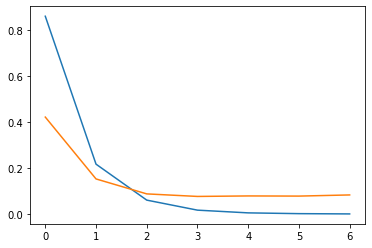

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


[[16.317676544189453, -6.205970764160156, -4.556171894073486, -9.08504581451416, -8.864522933959961], [0.9062448143959045, -3.8124616146087646, -4.443508148193359, -1.8600131273269653, -1.277788758277893], [4.763401508331299, -0.04256419092416763, -1.4611563682556152, -8.716155052185059, -4.418838977813721], [-2.1903834342956543, -1.3851268291473389, -8.908218383789062, -4.441577434539795, 1.258623719215393], [3.76153564453125, 0.9199509024620056, -3.2848923206329346, -7.176053524017334, -4.340432167053223], [-6.20352029800415, -11.163229942321777, -6.383193492889404, -0.5376202464103699, 6.028270721435547], [-1.445185899734497, -4.117951393127441, 1.3182508945465088, -8.97470760345459, -3.776360511779785], [-8.176910400390625, -10.798796653747559, -4.076937675476074, -5.514523945748806e-05, 5.231904029846191], [1.1724387407302856, -0.3817807137966156, -0.8926960229873657, -4.6278252601623535, -7.094975471496582], [-0.12943191826343536, -0.11423460394144058, -0.23949095606803894, -6.69

In [ ]:
import time
t1 = time.time()
val, model, text_field = main("train.csv", "test.csv")
print(val)
t2 = time.time()
print(t2-t1)

In [ ]:
import numpy as np
import sys
np.set_printoptions(threshold=sys.maxsize)

print("Test Predictions:")
val_np = np.array(val)
print(np.argmax(val_np, axis = 1))

In [ ]:
def softmax(x):
    """Compute softmax values for each sets of scores in x."""
    return np.exp(x) / np.sum(np.exp(x), axis=0)

def gui_predict(string):
  data = [string]
  df = pd.DataFrame(data, columns = ['reviews'])
  test_reviews = df.apply(lambda row: preprocess_review(row['reviews']), axis=1)
  test_reviews = perform_padding(test_reviews, text_field)
  test_reviews = text_field.numericalize(test_reviews)
  preds = model.predict(test_reviews, text_field, 1000)
  probs = softmax(preds[0])
  probs = list(probs)
  return probs

In [ ]:
gui_predict(text_gui)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


[0.09444954725878224,
 0.07917593572425437,
 0.6987068781435485,
 0.005663482399275363,
 0.12200415647413965]

In [ ]:
text_gui = 'I found that the adhesive did not hold as advertised. It is just okay.Not great !'

In [ ]:
"""
This stuff really works and at a fraction of the price of other products that claim to do the same thing. Almost looks like airbrushing.
I found that the adhesive did not hold as advertised. It is just okay.Not great !
"""

In [ ]:
data = ['This stuff really works and at a fraction of the price of other products that claim to do the same thing. Almost looks like airbrushing.',
        'I found that the adhesive did not hold as advertised. It is just okay.Not great !']
df = pd.DataFrame(data, columns = ['reviews'])
test_reviews = df.apply(lambda row: preprocess_review(row['reviews']), axis=1)
test_reviews = perform_padding(test_reviews, text_field)
test_reviews = text_field.numericalize(test_reviews)
# test_reviews, text_field=preprocess_data(df, 30)
v23 = model.predict(test_reviews, text_field, 1000)

v12 = np.argmax(v23, axis=1)

print('')
print('')
print('')
print(data[0], ' : ', v12[0]) 
print(' Probability: ', v23[0],'  ', test_reviews[0])
print('')
print('')

print(data[1], ' : ', v12[1]) 
print(' Probability: ', v23[1], '   ', test_reviews[1])
print('')
print('')


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))





This stuff really works and at a fraction of the price of other products that claim to do the same thing. Almost looks like airbrushing.  :  1
 Probability:  [-5.981274127960205, 5.417314529418945, -4.812644004821777, -3.823589563369751, 1.3837558031082153]    tensor([   7,   99,   38,   27,    5,   54,    6, 2908,   17,    4,   42,   17,
         103,  154,   31, 3428,    9,   83,    4,  230,  250,  401,  107,   28,
           0,    1,    1,    1,    1,    1])


I found that the adhesive did not hold as advertised. It is just okay.Not great !  :  2
 Probability:  [-4.887912750244141, -0.30836668610572815, 2.58689284324646, -1.0484970808029175, -2.938624858856201]     tensor([   3,  228,   31,    4, 1566,  124,   12,  277,   25,  333,    2,    8,
          40,  474,   12,   13,    1,    1,    1,    1,    1,    1,    1,    1,
           1,    1,    1,    1,    1,    1])




In [ ]:
from sklearn.metrics import classification_report

test_data = pd.read_csv('gold_test.csv')

# test_reviews, text_field=preprocess_data(test_data, 30)
test_reviews = test_data.apply(lambda row: preprocess_review(row['reviews']), axis=1)
test_reviews = perform_padding(test_reviews, text_field)
test_reviews = text_field.numericalize(test_reviews)
test_ratings = torch.tensor(test_data['ratings'].values)
test_ratings = test_ratings - 1
t1 = time.time()
val = model.predict(test_reviews, text_field, 1000)
t2 = time.time()
print(classification_report(test_ratings, np.argmax(val, axis=1)))
print('Time for inference:', t2-t1)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


              precision    recall  f1-score   support

           0       0.56      0.56      0.56      1271
           1       0.21      0.17      0.19       630
           2       0.29      0.26      0.27       911
           3       0.31      0.23      0.26      1404
           4       0.78      0.87      0.82      5784

    accuracy                           0.64     10000
   macro avg       0.43      0.42      0.42     10000
weighted avg       0.61      0.64      0.62     10000

Time for inference: 0.8857200145721436


In [ ]:
val_g = np.argmax(val, axis=1)

In [ ]:
""" Gold Test set Examples """

for i in [1999, 9975, 4207, 69, 46]:
  print("Sample sentence: ", test_data['reviews'][i])
  print("Sample sentence after preprocessing: ", preprocess_review(test_data['reviews'][i]))
  print("Rating: ", test_data['ratings'][i]-1)
  print("Prediction: ", val_g[i])
  print('')
  print('')
  print('')

In [ ]:
plt.hist(test_data['ratings'])

In [ ]:
plt.hist(train_data['ratings'])

In [ ]:
input_string =  "The earrings are very pretty but the size was bigger than I expected. I have a small ears so they were a lil big" #@param {type:"string"}

In [ ]:
import numpy as np
output_probs = gui_predict(input_string)
print("")
print("")
print("Probabilities of classes:")
print("="*30)
print("Probabilities of class 1: " + str(output_probs[0]))
print("Probabilities of class 2: " + str(output_probs[1]))
print("Probabilities of class 3: " + str(output_probs[2]))
print("Probabilities of class 4: " + str(output_probs[3]))
print("Probabilities of class 5: " + str(output_probs[4]))
print("")
print("")
pred_class = np.argmax(np.array(output_probs))+1
print("Predicted class: " + str(pred_class))


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))




Probabilities of classes:
Probabilities of class 1: 4.373827790988843e-05
Probabilities of class 2: 5.7897514971356456e-05
Probabilities of class 3: 0.961704208650559
Probabilities of class 4: 0.038115855513865114
Probabilities of class 5: 7.830004269467664e-05


Predicted class: 3
